## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

This project is an A/B test run by an e-commerce website. The company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. The goal is to help the company understand if they should implement this new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [30]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [31]:
# Read the data using Panda's read_csv function and store it in 'df'
df = pd.read_csv("ab_data.csv")

# Show the first 5 rows using head() function
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [32]:
# Show the number of rows using shape[0] function.
df.shape[0]

294478

c. The number of unique users in the dataset.

In [33]:
# Show the number of unique users using nunique() function on the 'user_id' column.
df.user_id.nunique()

290584

d. The proportion of users converted.

In [34]:
# Show the mean of converted users using mean() function
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [35]:
# Calculate how many rows that have (landing_page = new_page) and (group != treatment) and store it in 'no_lineup'
df[((df['landing_page'] == 'new_page') == (df['group'] != 'treatment'))].user_id.count()

3893

f. Do any of the rows have missing values?

In [36]:
# Check if the data has mising values using isnull() function
df[df.isnull()].user_id.count()

0

<font color='blue'>The are no missing vales.</font>

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

We should only use the rows that we can feel confident in the accuracy of the data. Therefore, the rows where treatment is not aligned with new_page or control is not aligned with old_page should be dropped.

In [37]:
df2 = df.query('(group == "treatment" & landing_page == "new_page") | (group == "control" & landing_page == "old_page")')
df2.shape[0]

290585

In [38]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [39]:
# Show the number of unique users using nunique() function on the 'user_id' column.
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [40]:
# Show the duplicated user id row using duplicated() function
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


<font color='blue'>The duplicated user_id is **773192**</font>

c. What is the row information for the repeat **user_id**? 

In [41]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


<font color='blue'>Only the **timestamp** in the two rows are different.</font>

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [42]:
# Delete one of the duplicated rows using drop function by its index value 
df2 = df2.drop(labels=1899, axis=0)

# Check if the row is deleted
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [43]:
# Show the mean of converted users using mean() function
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [44]:
# Show the mean of converted users in the control group using mean() function
df2[df2['group'] == 'control'].converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [45]:
# Show the mean of converted users in the treatment group using mean() function
df2[df2['group'] == 'treatment'].converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [46]:
# Show the mean of individuals received the new page using mean() function
(df2['landing_page'] == 'new_page').mean()

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

<font color='blue'>The probability of the converted users in the treatment group is 0.1188, whereas the probability of the converted users in the control group is 0.1204. The difference isn't significant (0.0016); therefore, there is no sufficient evidence to say that the new treatment page leads to more conversions.</font>

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_{0}: p_{new} - p_{old} \leq 0$$

$$H_{1}: p_{new} - p_{old} \gt 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [47]:
# Since 𝑝𝑛𝑒𝑤 and 𝑝𝑜𝑙𝑑 both they are equal to the converted rate in ab_data.csv regardless of the page, 
# I will use the mean() function for all the converted users
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [48]:
# Since 𝑝𝑛𝑒𝑤 and 𝑝𝑜𝑙𝑑 both they are equal to the converted rate in ab_data.csv regardless of the page, 
# I will use the mean() function for all the converted users
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [49]:
# Count the number of indivsuals in new_page using count() function and store it in n_new
n_new = df2[(df2['landing_page'] == 'new_page')].user_id.count()
n_new

145310

d. What is $n_{old}$?

In [50]:
# Count the number of indivsuals in old_page using count() function and store it in n_new
n_old = df2[(df2['landing_page'] == 'old_page')].user_id.count()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [51]:
new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1 - p_new), p_new]).mean()
new_page_converted

0.11935861262129241

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [52]:
old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1 - p_old), p_old]).mean()
old_page_converted

0.12059969437063756

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [54]:
new_page_converted - old_page_converted

-0.0012410817493451465

<font color='blue'>It is 0. Because here we are looking at a null where there is no difference in conversion based on the page, which means the conversions for each page are the same.</font>

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [55]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(n_new, p_new, 10000)/n_new
    old_page_converted = np.random.binomial(n_old, p_old, 10000)/n_old
    p_diffs = new_page_converted - old_page_converted 

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

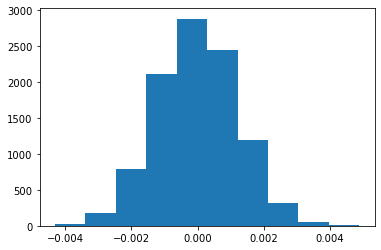

In [56]:
# Convert to numpy array
p_diffs = np.array(p_diffs)

# Plot sampling distribution
plt.hist(p_diffs);

<font color='blue'>The plot is normally distributed.</font>

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

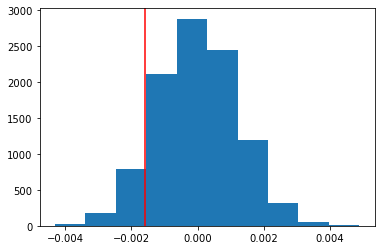

In [57]:
# Calculate the observed difference
obs_diff = (df2[df2['group'] == 'treatment'].converted.mean()) - (df2[df2['group'] == 'control'].converted.mean())
plt.hist(p_diffs)
plt.axvline(obs_diff, c='red');

In [59]:
# Calculate the proportion of the 'p_diffs' that are greater than the 'obs_diff', which is the p-value
(p_diffs >= obs_diff).mean()

0.904

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

<font color='blue'>I computed the probability that an observed difference could have occurred just by random chance in the data, this is called **p-value** in scientific studies. 

The p-value helps us to decide whether to reject the null hypothesis or not, depending on the alpha level. Here, the alpha level is equal to 0.05 and the p-value is 0.904, which means that the p-value is greater than the alpha level, therefore I failed to reject the null hypothesis, so *there's no sufficient evidence to convert to the new page*.</font>

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [60]:
import statsmodels.api as sm

convert_old = df2.query('converted == 1 & landing_page == "old_page"').user_id.count()
convert_new = df2.query('converted == 1 & landing_page == "new_page"').user_id.count()
n_old = df2[df2['landing_page'] == 'old_page'].user_id.count()
n_new = df2[df2['landing_page'] == 'new_page'].user_id.count()
convert_old, n_old, convert_new, n_new

(17489, 145274, 17264, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

<font color='green'>
Since the link is broken, I used this [link](https://www.statsmodels.org/devel/generated/statsmodels.stats.proportion.proportions_ztest.html) to help me test for proportions based on normal (z) test.</font>

In [61]:
stat, pval = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
stat, pval

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

<font color='blue'>Since the z-score is negative (-1.3109) and the p-value is pretty high (0.9051), I can't reject the null hypothesis. This conclusion agrees with the findings in parts j. and k. [This link helped me with the conclusion](https://towardsdatascience.com/demystifying-hypothesis-testing-with-simple-python-examples-4997ad3c5294)</font>

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

<font color='blue'>Since we only have two outcomes (binary), **logistic regression** is the appropriate type.</font>

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [62]:
# Create an intercept column
df2['intercept'] = 1

# Create dummy variable column (ab_page) using get_dummies() function for which page each user received
# This column is 1 when an individual receives the treatment and 0 if control
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

# Show the first 5 rows
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [63]:
#  Fit a logistic regression model to predict if an individual converts or not.
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [64]:
# Use the summary() function on the logistic model's results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 07 Aug 2021   Pseudo R-squ.:               8.077e-06
Time:                        21:32:08   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

<font color='blue'>The p-value associated with ab_page is 0.190, which is different from the p-value in Part II because of two reasons:
1. There is an intercept column in the logistic regression.
2. The logistic regression uses a two-sided alternative hypothesis test, whereas Part II used a one-sided alternative hypothesis test.

However, the p-value associated with ab_page (0.190) is still greater than the alpha level (0.05), which leads to the same conclusion: can't reject the null hypothesis.</font>

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

<font color='blue'>There may be other factors that *might* influence whether or not an individual converts such as, the users' age and their computer literacy level. Some people don't like changes, especially older ones, so they probably don't like the new page. Also, the computer literacy level may have a significant influence, if the user has fundamental skills, he/she prefer the simpler page. However, it might increase the complexity of the regression model without that significant improvement.</font>

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [65]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

# Show the first 5 rows of the new dataframe
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [66]:
# Get the unique vales in the country column
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [67]:
### Create the necessary dummy variables
df_new[['UK', 'US', 'CA']] = pd.get_dummies(df_new['country'])[['UK', 'US', 'CA']]

# Show the first 5 rows
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,CA
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0,0


In [68]:
# Get the interaction between page and country (higher order term) by creating two additional columns 
# which represent the interaction between them
df_new['UK_new'] = df_new['UK'] * df_new['ab_page']
df_new['US_new'] = df_new['US'] * df_new['ab_page']

# Show the first 5 rows
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,CA,UK_new,US_new
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,1,0,0,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [69]:
### Fit Your Linear Model And Obtain the Results
countries_log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US', 'UK_new', 'US_new']])
countries_results = countries_log_mod.fit()
countries_results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 07 Aug 2021   Pseudo R-squ.:               3.482e-05
Time:                        21:32:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK_new         0.0783      0.057      1.378      0.168      -0.033       0.190
US_new         0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

<font color='blue'>Since the p-values of UK (0.767), US (0.642) and all others are greater than the alpha level (0.05); thus, I can't reject the null hypothesis and the countries don't have influence on the convertion.</font>

<a id='conclusions'></a>
## Conclusions
According to the multiple tests done in this project, all the results couldn't reject the null hypothesis; meaning, there is no sufficient evidence to reject that the number of old page users who convert is greater than or equal to the number of new page users who convert. Therefore, the company should keep the old page.